C:\Users\thivi\anaconda3\Lib\site-packages\paramiko\transport.py:219: CryptographyDeprecationWarning: Blowfish has been deprecated
  "class": algorithms.Blowfish,
C:\Users\thivi\anaconda3\Lib\site-packages\cartopy\mpl\gridliner.py:451: UserWarning: The .xlabels_top attribute is deprecated. Please use .top_labels to toggle visibility instead.
  warnings.warn('The .xlabels_top attribute is deprecated. Please '
C:\Users\thivi\anaconda3\Lib\site-packages\cartopy\mpl\gridliner.py:487: UserWarning: The .ylabels_right attribute is deprecated. Please use .right_labels to toggle visibility instead.
  warnings.warn('The .ylabels_right attribute is deprecated. Please '


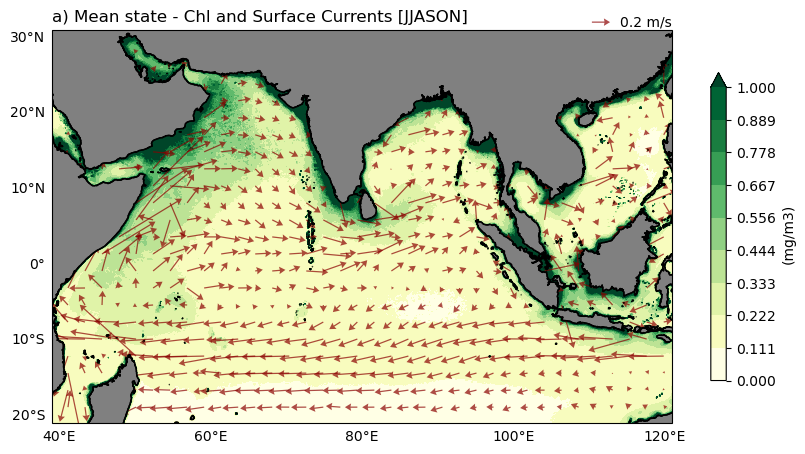

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import netCDF4 as nc
import scipy.stats as stats
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import matplotlib.ticker as mticker

# Load chlorophyll data
fn1 = './merged_CCI_ALL-v6.0-MONTHLY_97_23.nc'
ds = xr.open_dataset(fn1)
ds = ds.sel(time=slice('2003-01','2023-07'))

chl = ds.chlor_a
chl = chl.sel(lat=slice(31, -21))
chl = chl.sel(lon=slice(39, 121))

# Function to calculate mean values over specified months
def calculate_monthly_mean(data, months):
    data_selected = data.sel(time=np.in1d(data['time.month'], months))
    data_clm = data_selected.groupby('time.month').mean('time')
    return data_clm.mean('month')

average_chl = calculate_monthly_mean(chl, [6, 7, 8, 9, 10, 11])

# Load current data
fn2 = './sur_currents_cmems_obs_mob_glo_phy-cur_my_0.25deg_P1M-m_1715743039682.nc'
ds_currents = xr.open_dataset(fn2)
ds_currents = ds_currents.sel(time=slice('2003-01', '2023-07'))

ds_currents = ds_currents.sel(latitude=slice(-19, 30))
ds_currents = ds_currents.sel(longitude=slice(41, 120))

# Rename latitude and longitude coordinates
ds_currents = ds_currents.rename({'latitude': 'lat', 'longitude': 'lon'})

# Select surface currents (depth=0)
ds_currents = ds_currents.isel(depth=0)
u = ds_currents.uo
v = ds_currents.vo
u_average_chl = calculate_monthly_mean(u, [6, 7, 8, 9, 10, 11])
v_average_chl = calculate_monthly_mean(v, [6, 7, 8, 9, 10, 11])

# Function to plot the quiver
def uv_plot(ax, ur, vr):
    # Determine the dimensions of the u and v arrays
    n_dims = ur.shape

    # Create a grid of (x, y) coordinates matching the dimensions of u and v
    x, y = np.meshgrid(ur.lon, ur.lat)

    U = ur
    V = vr

    i = 9
    q = ax.quiver(x[::i, ::i], y[::i, ::i], U[::i, ::i], V[::i, ::i], color='darkred', alpha=0.7, headwidth=6, scale=1.1, scale_units='inches',
                  headlength=5, width=0.002, transform=ccrs.PlateCarree())

    # Add color to continents with scale='10m'
    ax.add_feature(cfeature.NaturalEarthFeature(
        category='physical', name='land', facecolor='gray', edgecolor='black', scale='10m'
    ))
    # Add coastlines
    ax.coastlines(resolution='10m', linewidth=1)

    # Add longitude and latitude to the axes and set custom formatters
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, linewidth=0, color='gray', alpha=0, linestyle='--')
    gl.xlabels_top = False  # Disable labels on top
    gl.ylabels_right = False  # Disable labels on the right
    gl.xlocator = mticker.MultipleLocator(base=20)  # Set longitude interval to 20 degrees
    gl.ylocator = mticker.MultipleLocator(base=10)  # Set latitude interval to 10 degrees
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER

    # Add a quiver key
    ax.quiverkey(q, X=0.90, Y=1.02, U=0.2, label='0.2 m/s', labelpos='E')

    return

# Create a Matplotlib figure and axis
fig = plt.figure(figsize=(10, 8))
ax = plt.axes(projection=ccrs.PlateCarree())

# Create contour plot for chlorophyll-a data
contour = average_chl.plot.contourf(ax=ax, levels=10, extend='max', vmin=0, vmax=1, cmap='YlGn', 
                                    cbar_kwargs={'shrink': 0.5, 'aspect': 20, 'label': '(mg/m3)'})

# Call uv_plot to plot the quiver wind arrows on the same axis
uv_plot(ax, u_average_chl, v_average_chl)

# Set the title of the plot and align it to the left
plt.title('a) Mean state - Chl and Surface Currents [JJASON]', loc='left')

# Show the plot
plt.show()